In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import seaborn as sns
from tqdm import tqdm
import datetime
import calendar
from collections import defaultdict


def report_metrics(y_true, y_pred):
    '''
    Output metrics of predictions vs truth
    '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, mape, r2


def month_str(time):
    '''
    Returns two strings representing the first and last day of time's month
    '''
    if time.month < 10:
        month_str = "0" + str(time.month)
    else:
        month_str = str(time.month)

    start_str = str(time.year) + "-" + month_str + "-01 00:14:00"
    last_day = calendar.monthrange(time.year, time.month)[1]
    end_str = str(time.year) + "-" + month_str + "-" + str(last_day) + " 23:59:00"
    return start_str, end_str


def year_str(time):
    '''
    Returns two strings representing the first and last day of time's year
    '''
    start_time = str(time.year) + "-01-01 00:14:00"
    end_time = str(time.year) + "-12-31 23:59:00"
    return start_time, end_time



class Normalised_Flow_Model:
    def __init__(self, train_report):
        self.time_range = pd.date_range("2019-03-19 00:14:00", "2022-04-08 23:59:00", freq="15min")
        # Don't include out of sync time values
        train_report_in_range = train_report[train_report.timestamp.isin(self.time_range)]
        self.predictions = train_report_in_range.groupby('timestamp')['total_volume_normalised'].median().to_frame().reset_index()
        self.true_mu = self.predictions.total_volume_normalised.sum() / len(self.time_range)
        self.empty_times = []
        
    def check_empties(self):
        for t in tqdm(self.time_range):
            if len( self.predictions[self.predictions.timestamp==t] ) <1:
                self.empty_times.append(t)
                
        print(f"{len(self.empty_times)} of {len(self.time_range)} time values are empty, {len(self.empty_times)/len(self.time_range) *100} %")
        
    def N(self,t):
        result = self.predictions[self.predictions.timestamp == t]
        if len(result) == 1:
            N_t = result.total_volume_normalised.to_numpy().item()
        else:
            N_t = 0
        return N_t
    
    
    def mean_N(self, date_range):
        '''
        Returns the average normalised volume over date_range
        '''
        N_t_in_date_range = self.predictions[self.predictions.timestamp.isin(date_range)]
        mean_N_t = N_t_in_date_range.total_volume_normalised.sum()/len(date_range)
        return mean_N_t
    
    def mean_N_year(self, time):
        '''
        Returns a prediction for the average normalised volume over a year
        '''
        # Get two strings representing the start and end of the year
        start_time, end_time = year_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t
        
        
    def mean_N_month(self, time):
        '''
        Returns a prediction for the average normalised volume over a month
        '''
        # Get two strings representing the start and end of the month
        start_time, end_time = month_str(time)
        # Use these strings to create a daterange
        date_range = pd.date_range(start_time, end_time, freq="15min")
        
        mean_N_t = self.mean_N(date_range)
        return mean_N_t

In [2]:
def get_reports(test_loc):
    test_report = pd.concat([v for k,v in reports.items() if k == test_loc])
    train_report = pd.concat([v for k,v in reports.items() if k != test_loc])
    return train_report, test_report

### Import Reports

In [3]:
# Import Traffic count predictions
traffic_predictions = pd.read_feather('predictions/traffic-counts/yolov5--Separate-Directions-LiveSpeed-RecallAdjusted')

# Import the traffic data to produce median models
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_birmingham_report_df_norm')
clean_manchester_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_manchester_report_df_norm')
clean_cambridge_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_cambridge_report_df_norm')
clean_thorpe_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_thorpe_report_df_norm')
clean_epping_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_epping_report_df_norm')
clean_bristol_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_bristol_report_df_norm')

# Import the reports that have the yearly data for all the sites
image_year_report_birmingham = pd.read_feather('image_year_traffic_reports/clean_birmingham_report_df')
image_year_report_manchester = pd.read_feather('image_year_traffic_reports/clean_manc_report_df')
image_year_report_cambridge = pd.read_feather('image_year_traffic_reports/clean_cam_report_df')
image_year_report_thorpe = pd.read_feather('image_year_traffic_reports/clean_thorpe_report_df')
image_year_report_epping = pd.read_feather('image_year_traffic_reports/clean_epping_report_df')
image_year_report_bristol = pd.read_feather('image_year_traffic_reports/clean_bristol_df')

# Put the Dataframe into dicts so that they can be eaility accessed
image_year_reports = {"birmingham": image_year_report_birmingham,
          "manchester" : image_year_report_manchester,
          "cambridge" : image_year_report_cambridge,
          "thorpe" : image_year_report_thorpe,
          "epping" : image_year_report_epping,
          "bristol" : image_year_report_bristol }

reports = {"birmingham": clean_birmingham_report_df_norm,
          "manchester" : clean_manchester_report_df_norm,
          "cambridge" : clean_cambridge_report_df_norm,
          "thorpe" : clean_thorpe_report_df_norm,
          "epping" : clean_epping_report_df_norm,
          "bristol" : clean_bristol_report_df_norm }


times = {"birmingham": datetime.datetime(2021,6,15,12,14),
          "manchester" : datetime.datetime(2019,4,19,12,59),
          "cambridge" : datetime.datetime(2021,11,2,12,29),
          "thorpe" : datetime.datetime(2022,3,8,12,14),
          "epping" : datetime.datetime(2022,3,8,12,14),
          "bristol" : datetime.datetime(2020,8,8,12,14) }

In [4]:
def plot_actual_v_pred(avg_flows, avg_flow_preds, name='AADT'):
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(x=avg_flow_preds, y=avg_flows, ax=ax)
    # lims of the y=x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.5)
    plt.xlabel(f'Predicted {name}')
    plt.ylabel(f'Actual {name}')
    plt.show()

In [5]:
def model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model):
    ''' 
    Function that applies a traffic model to the area test_report and the predictions from traffic_predictions_focus and outputs the results
    '''
    
    avg_flow_preds_sat = []
    avg_flow_preds = []
    avg_flows = []    
    # For each site in the test area estimate the average flow over date_range
    for sites_str in traffic_predictions_focus.sites:
        site_list = sites_str.replace(' ', '').split(',')
        
        # Obtain the true traffic flow for site_list
        test_report_site = test_report[(test_report.site_id.isin(site_list)) & (test_report.timestamp.isin(date_range))]
        avg_flow = test_report_site.groupby('time_period_ending')['total_volume'].mean().mean()
        
        # Obtain the count values for site_list
        X_t_values = test_report_site[test_report_site.timestamp == time].total_volume
        # Take the mean of these count values
        X_t = X_t_values.mean()
        # Make a prediction of avg_flow from the true counts
        avg_flow_pred = X_t/model.N(time) * model.mean_N(date_range)
        
        # Obtain the count values via satellite for site_list
        X_t_sat = traffic_predictions_focus[traffic_predictions_focus.sites == sites_str].all_vehicle_pred.to_numpy()
        # Make a prediction of avg_flow from the satellites counts
        avg_flow_pred_sat = X_t_sat/model.N(time) * model.mean_N(date_range)
        
        avg_flows.append(avg_flow)
        avg_flow_preds.append(avg_flow_pred.item())
        avg_flow_preds_sat.append(avg_flow_pred_sat.item())
        
        
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    return avg_flows, avg_flow_preds, avg_flow_preds_sat

In [6]:
def test_area(area, model, AADT = True):
    traffic_predictions_focus = traffic_predictions[traffic_predictions.area == area]
    test_report = image_year_reports[area]
    time = times[area]
    if AADT:
        start_str, end_str = year_str(time)
    else:
        start_str, end_str = month_str(time)
        
    date_range = pd.date_range(start_str, end_str, freq="15min")
    return model_window_satellite(test_report, time, date_range, traffic_predictions_focus, model)

<AxesSubplot:xlabel='area', ylabel='count'>

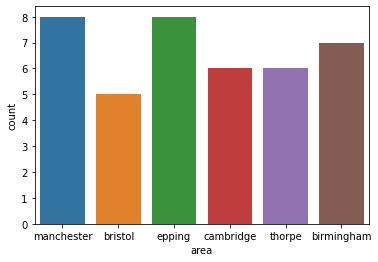

In [7]:
sns.countplot(x = traffic_predictions.area)

## Results on train vs test set

### AADT

In [8]:
AADT_sat_results = defaultdict(str)
AADT_sat_results_train = defaultdict(str)

areas = ["birmingham", "cambridge", "bristol", "manchester"]
for area in areas:
    print(area)
    
    train_report, __ = get_reports(area)
    model = Normalised_Flow_Model(train_report)
    
    AADT_sat_results[area] = test_area(area, model) # avg_flows, avg_flow_preds, avg_flow_preds_sat
    
    # Get restuls with the same model on the traiing areas
    for other_area in [other_area for other_area in areas if other_area != area ]:
        avg_flows, avg_flow_preds, avg_flow_preds_sat = [], [], []
        
        flows, flow_preds, flow_preds_sat = test_area(other_area, model)
        
        avg_flows += flows
        avg_flow_preds += flow_preds
        avg_flow_preds_sat += flow_preds_sat
        
        AADT_sat_results_train[other_area] = avg_flows, avg_flow_preds, avg_flow_preds_sat

birmingham
cambridge
bristol
manchester


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  9309.42 		 MSE: 6560.27 		 MSE: 5785.28
MAE:  84.46  		 MAE: 61.98 		 MAE: 57.33
MAPE: 0.36 		 MAPE: 0.17 		 MAPE 0.17
R^2:  0.81 		 R^2: 0.86 		 R^2: 0.88


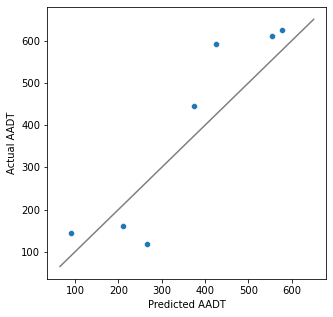

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  14155.67 		 MSE: 461.98 		 MSE: 573.8
MAE:  101.87  		 MAE: 18.87 		 MAE: 20.83
MAPE: 0.29 		 MAPE: 0.06 		 MAPE 0.07
R^2:  -2.68 		 R^2: 0.88 		 R^2: 0.85


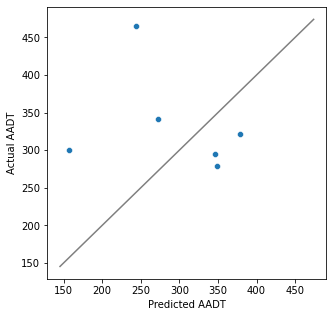

Area bristol
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  25670.49 		 MSE: 5137.48 		 MSE: 4608.78
MAE:  138.07  		 MAE: 58.85 		 MAE: 47.57
MAPE: 0.37 		 MAPE: 0.16 		 MAPE 0.13
R^2:  -4.23 		 R^2: -0.05 		 R^2: 0.06


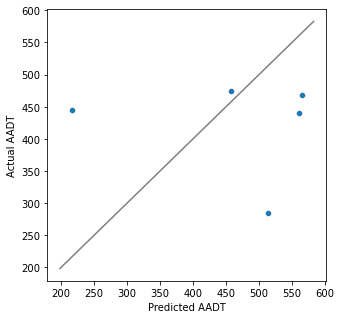

Area manchester
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  82750.46 		 MSE: 43390.23 		 MSE: 34305.38
MAE:  269.75  		 MAE: 198.15 		 MAE: 174.54
MAPE: 0.45 		 MAPE: 0.33 		 MAPE 0.29
R^2:  -2.51 		 R^2: -0.84 		 R^2: -0.45


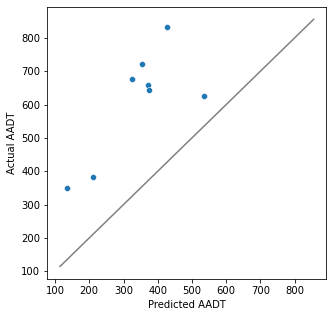

In [9]:
# Print and plot results

for location, AADT_result in AADT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AADT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AADT_sat_results_train[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_train, avg_flow_preds_train)
    mse_gl, mae_gl, mape_gl, r2_gl = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count metrics for local training')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gl, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gl, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gl, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gl, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AADT')

### AMDT

In [10]:
AMDT_sat_results = defaultdict(str)
AMDT_sat_results_train = defaultdict(str)

areas = ['birmingham', 'manchester', 'cambridge', 'thorpe', 'epping', 'bristol']
for area in areas:
    print(area)
    
    train_report, __ = get_reports(area)
    model = Normalised_Flow_Model(train_report)
    
    AMDT_sat_results[area] = test_area(area, model, AADT = False) # avg_flows, avg_flow_preds, avg_flow_preds_sat
    
    # Get restuls with the same model on the traiing areas
    for other_area in [other_area for other_area in areas if other_area != area ]:
        avg_flows, avg_flow_preds, avg_flow_preds_sat = [], [], []
        
        flows, flow_preds, flow_preds_sat = test_area(other_area, model, AADT = False)
        
        avg_flows += flows
        avg_flow_preds += flow_preds
        avg_flow_preds_sat += flow_preds_sat
        
        AMDT_sat_results_train[other_area] = avg_flows, avg_flow_preds, avg_flow_preds_sat

birmingham
manchester
cambridge
thorpe
epping
bristol


Area birmingham
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  9298.88 		 MSE: 5458.5 		 MSE: 4601.68
MAE:  83.12  		 MAE: 58.7 		 MAE: 52.92
MAPE: 0.33 		 MAPE: 0.15 		 MAPE 0.15
R^2:  0.83 		 R^2: 0.9 		 R^2: 0.92


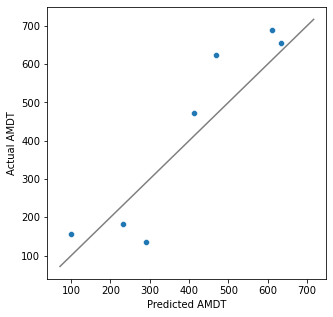

Area manchester
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  40407.83 		 MSE: 9949.39 		 MSE: 6542.46
MAE:  187.17  		 MAE: 83.63 		 MAE: 65.43
MAPE: 0.32 		 MAPE: 0.15 		 MAPE 0.12
R^2:  -0.76 		 R^2: 0.57 		 R^2: 0.71


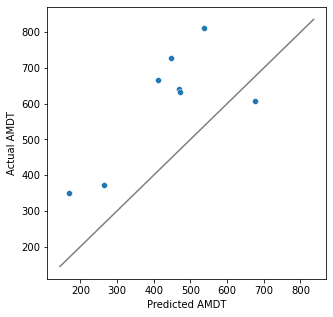

Area cambridge
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  14310.89 		 MSE: 606.3 		 MSE: 512.19
MAE:  105.14  		 MAE: 20.57 		 MAE: 18.95
MAPE: 0.28 		 MAPE: 0.05 		 MAPE 0.05
R^2:  -4.63 		 R^2: 0.76 		 R^2: 0.8


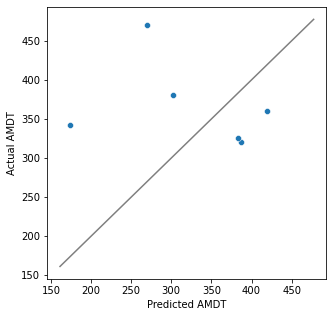

Area thorpe
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  1905.06 		 MSE: 1627.4 		 MSE: 1573.07
MAE:  33.12  		 MAE: 31.39 		 MAE: 31.73
MAPE: 0.04 		 MAPE: 0.04 		 MAPE 0.04
R^2:  0.92 		 R^2: 0.93 		 R^2: 0.93


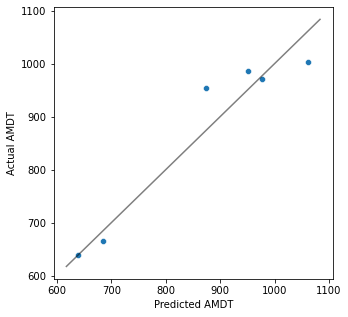

Area epping
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  34736.98 		 MSE: 2250.44 		 MSE: 2189.62
MAE:  144.76  		 MAE: 44.36 		 MAE: 43.22
MAPE: 0.21 		 MAPE: 0.07 		 MAPE 0.07
R^2:  -1.83 		 R^2: 0.82 		 R^2: 0.82


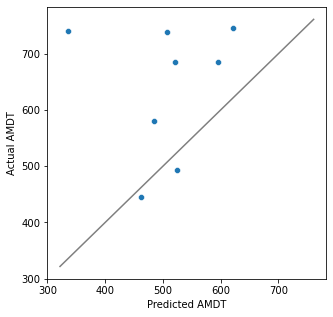

Area bristol
Satellite Metrics 	 Gold count metrics 	 Gold count metrics for local training
MSE:  38318.77 		 MSE: 10789.39 		 MSE: 10667.89
MAE:  154.62  		 MAE: 74.48 		 MAE: 73.19
MAPE: 0.3 		 MAPE: 0.14 		 MAPE 0.14
R^2:  -3.77 		 R^2: -0.34 		 R^2: -0.33


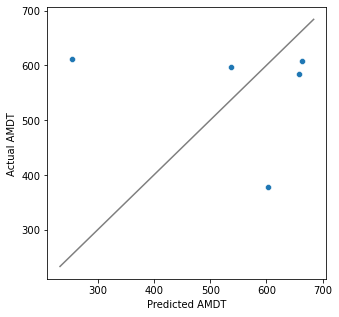

In [11]:
# Print and plot results

for location, AMDT_result in AMDT_sat_results.items():
    print(f"Area {location}")
    avg_flows, avg_flow_preds, avg_flow_preds_sat = AMDT_result
    avg_flows_train, avg_flow_preds_train, avg_flow_preds_sat_train = AMDT_sat_results_train[location]
    
    metrics_satellite_counts = report_metrics(avg_flows, avg_flow_preds_sat)
    mse_s, mae_s, mape_s, r2_s = metrics_satellite_counts
    
    metrics_gold_counts = report_metrics(avg_flows, avg_flow_preds)
    mse_g, mae_g, mape_g, r2_g = metrics_gold_counts
    
    metrics_gold_counts_train = report_metrics(avg_flows_train, avg_flow_preds_train)
    mse_gl, mae_gl, mape_gl, r2_gl = metrics_gold_counts_train
    
    print('Satellite Metrics \t Gold count metrics \t Gold count metrics for local training')
    print(f"MSE:  {str(round(mse_s, 2))} \t\t MSE: {str(round(mse_g, 2))} \t\t MSE: {str(round(mse_gl, 2))}")
    print(f"MAE:  {str(round(mae_s, 2))}  \t\t MAE: {str(round(mae_g, 2))} \t\t MAE: {str(round(mae_gl, 2))}")
    print(f"MAPE: {str(round(mape_s, 2))} \t\t MAPE: {str(round(mape_g, 2))} \t\t MAPE {str(round(mape_gl, 2))}")
    print(f"R^2:  {str(round(r2_s, 2))} \t\t R^2: {str(round(r2_g, 2))} \t\t R^2: {str(round(r2_gl, 2))}")
    
    
    plot_actual_v_pred(avg_flows, avg_flow_preds_sat, name='AMDT')

## Local Model vs Global Model

### AADT

### ADMT